## Heuristic Code

In [12]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import itertools
import operator
import networkx as nx

import warnings
warnings.filterwarnings('ignore')


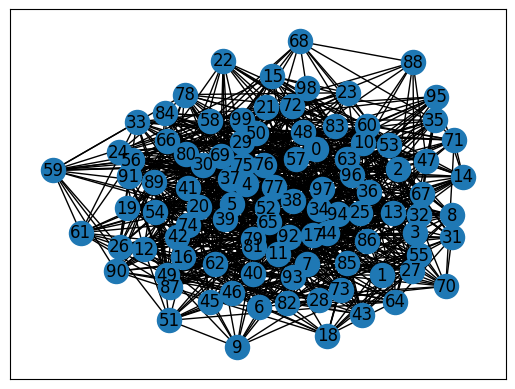

In [13]:
from networkx.generators.random_graphs import erdos_renyi_graph
import networkx as nx

v = 100
p = 0.20
G = erdos_renyi_graph(v, p)
#G = nx.barabasi_albert_graph(100, 2)
E=[]
for i in G.edges:
  E.append(i)

allowedWeightValues = list(range(1,5))  #allowedWeightValues = [1, 2, 3, 4, 5]
noOfEdges = len(E)
g = ig.Graph(v, E)

nx.draw_networkx(G)

In [14]:
def findSEPR(path, WT):
  sEPR = max(WT)
  for i in range(len(path[0])-1):
    if (path[0][i],path[0][i+1]) in E:
      index = E.index((path[0][i],path[0][i+1]))
    else:
      index = E.index((path[0][i+1],path[0][i]))
    if sEPR >= WT[index]:
      sEPR = WT[index]
  return sEPR
def updatePathWeight(path, pathWeight, updateFactor):
  for i in range(len(path[0])-1):
    if (path[0][i],path[0][i+1]) in E:
      index = E.index((path[0][i],path[0][i+1]))
    else:
      index = E.index((path[0][i+1],path[0][i]))
    pathWeight[index] = pathWeight[index] - updateFactor
  return pathWeight

In [15]:
def intersection(lst1, lst2):
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3

In [16]:
AllPath = dict()
def getAllShortestPath(NodePairs):
  AllPath.clear()
  for (x,y) in NodePairs:
    if AllPath.get(x) == None:
      AllPath[x] = {}
    AllPath[x][y] = [p for p in nx.all_simple_paths(G, x, y)]

In [17]:
AllPathsEPR = dict()
def getAllsEPR(NodePairs, WT):
  AllPathsEPR.clear()
  for (x,y) in NodePairs:
    if AllPathsEPR.get(x) == None:
      AllPathsEPR[x] = {}
    if AllPathsEPR[x].get(y) == None:
      AllPathsEPR[x][y] = {}
    k=0
    for p in AllPath[x][y]:
      AllPathsEPR[x][y][k] = findSEPR([p],WT)
      k+=1

In [18]:
def splitSchedulingLP(SN):
  RD,RDT,RsPathL,RsPaths,RDN, RST = [list(t) for t in zip(*SN)]
  T = max(RDT)
  SCHD = [[] for i in range(0,T)]
  WT = [[x for x in W] for i in range(0,T)]
  EPRServed = 0
  DServed = 0
  for i in range(len(RD)):
    RX = [p for p in nx.all_simple_paths(G, RDN[i][0], RDN[i][1], 2)]
    RX.sort(key=len)
    for counter, path in enumerate(RX):
      if RD[i]>0:
        t = RST[i]
        while t < RDT[i] and RD[i]>0:
          sEPR = findSEPR([path], WT[t])
          if sEPR>0:
            if RD[i] > sEPR:
              SCHD[t].append((RDN[i],sEPR))
              EPRServed += sEPR
              RD[i] -= sEPR
              WT[t] = updatePathWeight([path], WT[t], sEPR)
              t = t + 1
            else:
              EPRServed += RD[i]
              WT[t] = updatePathWeight([path], WT[t], RD[i])
              SCHD[t].append((RDN[i],RD[i]))
              RD[i] = 0
              DServed += 1
              break
          else:
            t = t + 1;
      else:
        break
  return EPRServed, SCHD, DServed

## LP Code

In [19]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.mp.vartype import VarType
import json

In [20]:
def generate_weight_matrix(nb_nodes, p, min_weight, max_weight, debug=False):
    # er_graph = np.random.choice([0, 1], size=(nb_nodes, nb_nodes), p=[1 - p, p])
    # np.fill_diagonal(er_graph, 0)   
    G = nx.erdos_renyi_graph(nb_nodes, p)
    er_graph = nx.to_numpy_array(G)
    weights = np.random.randint(min_weight, max_weight, size=(nb_nodes, nb_nodes))
    W_adj = er_graph * weights
    W_adj = (W_adj + W_adj.T) // 2
    if debug:
        print(f"Weight Matrix:\n{W_adj}")
    return G, W_adj

In [21]:
def generate_demands(nb_demands, nb_nodes, nb_timesteps, max_eprs, debug=False):
    demand_sizes = np.random.randint(1, max_eprs, size=nb_demands)

    all_pairs = []
    for i in range(nb_nodes):
        for j in range(nb_nodes):
            if i != j:
                all_pairs.append((i, j))
    demand_pairs = random.choices(all_pairs, k=nb_demands)
    start_nodes, end_nodes = list(zip(*demand_pairs))

    all_intervals = []
    for i in range(nb_timesteps):
        for j in range(i + 1, nb_timesteps):
            all_intervals.append((i, j))
    demand_intervals = random.choices(all_intervals, k=nb_demands)
    start_times, end_times = list(zip(*demand_intervals))

    return start_nodes, end_nodes, demand_sizes, start_times, end_times

In [22]:
def create_digraph(W_adj):
    nb_nodes = W_adj.shape[0]
    labels = [i for i in range(nb_nodes)]
    W_df = pd.DataFrame(W_adj, index=labels, columns=labels)
    G_digraph = nx.from_pandas_adjacency(W_df, create_using=nx.DiGraph())
    return G_digraph

In [23]:
def plot_digraph(G, filename):
    plt.figure()
    positions = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, positions)
    nx.draw_networkx_edges(G, pos=positions, width=1.0)
    edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels)
    nx.draw_networkx_labels(G, positions)
    # plt.savefig(filename)
    plt.show()

In [24]:
def add_variables(model, W_adj, nb_demands, nb_timesteps, nb_nodes, debug=False):
    variables = model.integer_var_dict(
        [
            (i, t, u, v)
            for i in range(nb_demands)
            for t in range(nb_timesteps)
            for u in range(nb_nodes)
            for v in range(nb_nodes)
            if W_adj[u][v] != 0
        ],
        name="f",
    )
    if debug:
        for var_key in variables:
            print(variables[var_key].name)
    return variables

In [25]:
def define_objective(model, W_adj, nb_demands, nb_nodes, demand_list, variables, debug=False):
    objective = 0
    for i in range(nb_demands):
        for t in range(demand_list[i][3], demand_list[i][4], 1):
            for v in range(nb_nodes):
                if W_adj[demand_list[i][0]][v] != 0:
                    if debug: 
                        print(
                            (i, t, demand_list[i][0], v),
                            variables[(i, t, demand_list[i][0], v)],
                        )
                        print()
                    objective += (
                        variables[(i, t, demand_list[i][0], v)]
                        - variables[(i, t, v, demand_list[i][0])]
                    )
    model.maximize(objective)

In [26]:
def define_constraints(
    model,
    W_adj,
    nb_timesteps,
    nb_demands,
    nb_nodes,
    demand_list,
    variables,
    nw_state,
    debug=False,
):
    # Constraint 1
    source_outflow = []
    for i in range(nb_demands):
        sum_allocated = model.linear_expr()
        for t in range(demand_list[i][3], demand_list[i][4], 1):
            for v in range(nb_nodes):
                if W_adj[demand_list[i][0]][v] != 0:
                    sum_allocated += variables[(i, t, demand_list[i][0], v)]
        model.add_constraint(
            sum_allocated <= demand_list[i][2],
            f"outflow_src_demand_{i}_src_{demand_list[i][0]}",
        )
        source_outflow.append(sum_allocated)
        if debug:
            print(
                model.get_constraint_by_name(
                    f"outflow_src_demand_{i}_src_{demand_list[i][0]}"
                )
            )
            print()

    # Constraint 2
    for i in range(nb_demands):
        sum_allocated = model.linear_expr()
        for t in range(demand_list[i][3], demand_list[i][4], 1):
            for u in range(nb_nodes):
                if W_adj[u][demand_list[i][1]] != 0:
                    sum_allocated += variables[(i, t, u, demand_list[i][1])]
        model.add_constraint(
            sum_allocated == source_outflow[i],
            f"inflow_dest_demand_{i}_dst_{demand_list[i][1]}",
        )
        if debug:
            print(
                model.get_constraint_by_name(
                    f"inflow_dest_demand_{i}_dst_{demand_list[i][1]}"
                )
            )
            print()

    # Constraint 3
    for i in range(nb_demands):
        for t in range(nb_timesteps):
            for v in range(nb_nodes):
                if v not in (demand_list[i][0], demand_list[i][1]):
                    inflow_v = model.linear_expr()
                    outflow_v = model.linear_expr()
                    for u in range(nb_nodes):
                        if W_adj[u][v] != 0:
                            inflow_v += variables[(i, t, u, v)]
                            outflow_v += variables[(i, t, v, u)]
                    if debug:
                        print(f"INFLOW_I_{i}_T_{t}_V_{v} = {inflow_v}")
                        print(f"OUTFLOW_I_{i}_T_{t}_V_{v} = {outflow_v}")
                    model.add_constraint(
                        inflow_v == outflow_v, f"flow_cons_node_i_{i}_t_{t}_v_{v}"
                    )
                    if debug:
                        print(
                            model.get_constraint_by_name(
                                f"flow_cons_node_i_{i}_t_{t}_v_{v}"
                            )
                        )

    # Constraint 4
    for t in range(nb_timesteps):
        for u in range(nb_nodes):
            for v in range(nb_nodes):
                if W_adj[u][v] != 0:
                    sum_allocated = model.linear_expr()
                    for i in range(nb_demands):
                        sum_allocated += variables[(i, t, u, v)]
                    model.add_constraint(
                        sum_allocated <= nw_state[t][u][v],
                        f"edge_capacity_{u}_{v}_t_{t}",
                    )
                    if debug:
                        print(
                            model.get_constraint_by_name(f"edge_capacity_{u}_{v}_t_{t}")
                        )
                        print()

    # Constraint 5
    for i in range(nb_demands):
        sum_allocated = model.linear_expr()
        dont_allocate_time = [
            t
            for t in range(0, nb_timesteps)
            if t not in range(demand_list[i][3], demand_list[i][4])
        ]
        if debug:
            print(
                f"dont allocate time for req: {demand_list[i]} = {dont_allocate_time}"
            )
        for t in dont_allocate_time:
            for u in range(nb_nodes):
                for v in range(nb_nodes):
                    if W_adj[u][v] != 0:  # edge u->v
                        sum_allocated += variables[(i, t, u, v)]
        model.add_constraint(sum_allocated == 0, f"no_allocation_bef_after_req_{i}")
        # DEBUG PRINTING
        if debug:
            print(model.get_constraint_by_name(f"no_allocation_bef_after_req_{i}"))
            print()

    # Constraint 6
    for i in range(nb_demands):
        for t in range(demand_list[i][3], demand_list[i][4], 1):
            sum_allocated = model.linear_expr()
            for u in range(nb_nodes):
                for v in range(nb_nodes):
                    if W_adj[u][v] != 0:  # edge from  u -> v
                        sum_allocated += variables[(i, t, u, v)]
            model.add_constraint(
                sum_allocated <= demand_list[i][2],
                f"max_allocation_demand_{i}_t_{t}",
            )
            if debug:
                print(model.get_constraint_by_name(f"max_allocation_demand_{i}_t_{t}"))
                print()

In [27]:
def generate_flow_matrix(vars, nb_demands, nb_timesteps, nb_nodes, debug=False):
    F = np.zeros(shape=(nb_demands, nb_timesteps, nb_nodes, nb_nodes))
    # print("")
    # print("")
    # print("FLOWS")
    # print("-------------------")
    # print("[i, t, u, v] | flow")
    # print("-------------------")
    for v in vars:
        if v["value"] != 0:
            id = v["name"]
            id = id.split("_")[1:]
            id = list(map(int, id))
            F[id[0], id[1], id[2], id[3]] = float(v["value"])
            # print(f"{id} | {v['value']}")
    # print("-------------------")
    return F

In [28]:
def compute_served(F, demand_list):
    nb_demands = len(demand_list)
    served_count = 0
    total_eprs = 0
    for i in range(nb_demands):
        eprs_served = 0
        for t in range(F.shape[1]):
            for v in range(F.shape[2]):
                eprs_served += F[i][t][demand_list[i][0]][v]
        if eprs_served == demand_list[i][2]:
            served_count += 1
            # print(f"Served demand {i}")
        total_eprs += eprs_served

    # print(f"Served {served_count} out of {nb_demands} demands.")
    return served_count, total_eprs

**vDensity**

In [29]:
def path_and_time_intersection(p1, p2, st1, et1, st2, et2):
  if (et1<=st2) or (et2<=st1):
    return []
  temp = set(p2)
  lst3 = [value for value in p1 if value in temp]
  return lst3

In [30]:

from networkx.generators.random_graphs import erdos_renyi_graph
import networkx as nx
from numpy import arange

lowerBound = 0.2
upperBound = 1
step = 0.1
iteration = (upperBound-lowerBound)//step
edge = []

#To ensure probabilistic nature, we need to repeat each 'number_of_demands' multiple times and average out for each 'number_of_demands'
average_eprres = [0 for i in arange(lowerBound, upperBound, step)]
average_dres = [0 for i in arange(lowerBound, upperBound, step)]

average_eprres_lp = [0 for i in arange(lowerBound, upperBound, step)]
average_dres_lp = [0 for i in arange(lowerBound, upperBound, step)]

num_trials = 10


v = 15

for trial in range(num_trials):
  # Heuristic Part

  print('trial:', trial)
  k = 100
  allowedWeightValues = list(range(1,5))
  eprres = []
  dres = []
  eprres_lp = []
  dres_lp = []
  start_nodes, end_nodes, D, DST, DT = generate_demands(nb_demands=k, nb_nodes=v, nb_timesteps=10, max_eprs=15)
  DN = list(zip(start_nodes, end_nodes))
  # DN = random.sample(list((x,y) for x,y in itertools.product(range(v), repeat = 2) if x!=y), k=k) # Demand Nodes (start_node, end_node)
  # D = random.choices(list(range(1,15)), k=k) # Demand Sizes
  # DT = random.choices(list(range(5,10)), k=k) #End Time
  # DST = random.choices(list(range(0,5)), k=k) #Start time for each demand
  BurstDuration = [DT[i] - DST[i] for i in range(len(D))]
  for i in np.arange(lowerBound, upperBound, step):
    print('density:', i)
    G, W_adj = generate_weight_matrix(v, i, 1, 5)
    
    E=[]
    for j in G.edges:
      E.append(j)
    noOfEdges = len(E)
    edge.append(noOfEdges)
    g = ig.Graph(v, E)
    W = list(W_adj[W_adj != 0])
    sPaths = list()
    sPathL = []
    for j in DN:
      shortestPath = g.get_shortest_paths(j[0], to=j[1], output="vpath")
      sPaths.append(shortestPath)
      sPathL.append(len(shortestPath[0])-1)
    ST  = [0 for a in range(len(D))]
    m = 0
    Paths = sPaths
    P = [0 for i in range(len(Paths))]
    for l in Paths:
      P[m] = []
      for q in l:
        for i in range(len(q)-1):
          P[m].append((q[i], q[i+1]))
      m += 1
    S = sorted(zip(D, DT, sPathL, sPaths, DN, DST), key = lambda x: (x[1], x[0], x[2])) #EPR Maximization --- sorted
    eprserved, schd, dserved = splitSchedulingLP(S)
    eprres.append(eprserved/sum(D))
    dres.append(dserved/len(D))
    
    #LP Part
    network_state = [W_adj] * (10 + 1)

    model = Model(name="routing", log_output=False)
    model.objective_sense = "max"
    model.parameters.threads.set(1)
    G_base = create_digraph(W_adj)
    variables = add_variables(model=model, W_adj=W_adj,nb_demands=k, nb_timesteps=10, nb_nodes=v)
    define_objective(model=model, W_adj=W_adj, nb_demands=k, nb_nodes=v, demand_list=list(zip(start_nodes, end_nodes, D, DST, DT)), variables=variables)
    define_constraints(model=model, W_adj=W_adj, nb_timesteps=10, nb_demands=k, nb_nodes=v, demand_list=list(zip(start_nodes, end_nodes, D, DST, DT)), variables=variables, nw_state=network_state)
    solution = model.solve()
    if solution is None:
      dserved_lp = eprsserved_lp = 0
    else:
      sol_json = solution.export_as_json_string()
      vars = json.loads(sol_json)["CPLEXSolution"]["variables"]
      F = generate_flow_matrix(vars, nb_demands=k, nb_timesteps=10, nb_nodes=v)
      dserved_lp, eprserved_lp = compute_served(F, list(zip(start_nodes, end_nodes, D, DST, DT)))
    eprres_lp.append(eprserved_lp/sum(D))
    dres_lp.append(dserved_lp/len(D))
    
    

  for i in range(len(eprres)):
    position = i
    average_eprres[position] = average_eprres[position] + eprres[position]
    average_dres[position] = average_dres[position] + dres[position]
    
    average_eprres_lp[position] = average_eprres_lp[position] + eprres_lp[position]
    average_dres_lp[position] = average_dres_lp[position] + dres_lp[position]
    
  for i in range(len(eprres)):
    position = i
    average_eprres[position] = average_eprres[position]/num_trials
    average_dres[position] = average_dres[position]/num_trials
    
    average_eprres_lp[position] = average_eprres_lp[position]/num_trials
    average_dres_lp[position] = average_dres_lp[position]/num_trials

trial: 0
density: 0.2


density: 0.30000000000000004
density: 0.4000000000000001
density: 0.5000000000000001
density: 0.6000000000000001
density: 0.7000000000000002
density: 0.8000000000000003
density: 0.9000000000000001
trial: 1
density: 0.2
density: 0.30000000000000004
density: 0.4000000000000001
density: 0.5000000000000001
density: 0.6000000000000001
density: 0.7000000000000002
density: 0.8000000000000003
density: 0.9000000000000001
trial: 2
density: 0.2
density: 0.30000000000000004
density: 0.4000000000000001
density: 0.5000000000000001
density: 0.6000000000000001
density: 0.7000000000000002
density: 0.8000000000000003
density: 0.9000000000000001
trial: 3
density: 0.2
density: 0.30000000000000004
density: 0.4000000000000001
density: 0.5000000000000001
density: 0.6000000000000001
density: 0.7000000000000002
density: 0.8000000000000003
density: 0.9000000000000001
trial: 4
density: 0.2
density: 0.30000000000000004
density: 0.4000000000000001
density: 0.5000000000000001
density: 0.6000000000000001
density: 0.

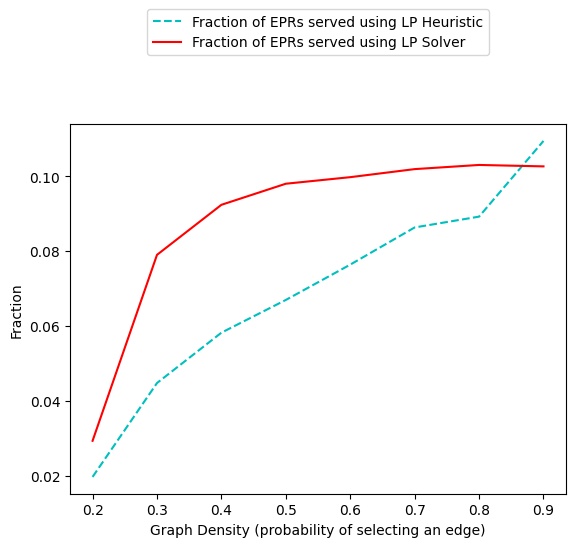

In [33]:
timeArray = np.arange(lowerBound, upperBound, step)

plt.plot(timeArray, average_eprres, color='c', label='Fraction of EPRs served using LP Heuristic', linestyle = 'dashed')
plt.plot(timeArray, average_eprres_lp, color='r', label='Fraction of EPRs served using LP Solver')

plt.xlabel("Graph Density (probability of selecting an edge)")
plt.ylabel("Fraction")
#plt.title("Demand Fullfilmet Schedule")

plt.legend()
plt.legend(bbox_to_anchor=(0.5, 1.33), loc='upper center')
plt.savefig('vsGraphDensity.png', bbox_inches='tight', dpi=500)
plt.show()

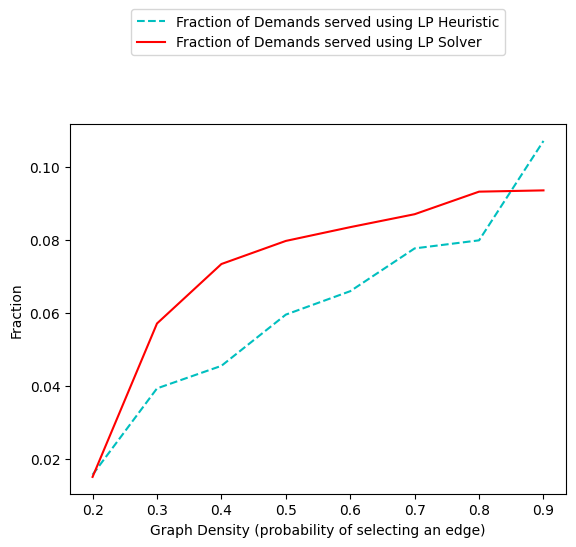

In [34]:
timeArray = np.arange(lowerBound, upperBound, step)

plt.plot(timeArray, average_dres, color='c', label='Fraction of Demands served using LP Heuristic', linestyle = 'dashed')
plt.plot(timeArray, average_dres_lp, color='r', label='Fraction of Demands served using LP Solver')

plt.xlabel("Graph Density (probability of selecting an edge)")
plt.ylabel("Fraction")
#plt.title("Demand Fullfilmet Schedule")

plt.legend()
plt.legend(bbox_to_anchor=(0.5, 1.33), loc='upper center')
plt.savefig('vsGraphDensity.png', bbox_inches='tight', dpi=500)
plt.show()